# JUPYTER NOTEBOOK FOR HOMEWORK 4
Using classifiers to identify very noisy images of faces with happy or sad expressions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
#from helper import getBinaryfer13Data, sigmoid, sigmoid_cost, error_rate
from helper import y2indicator, getBinaryfer13Data, sigmoid, sigmoid_cost, error_rate, init_weight_and_bias, \
                    init_weight_and_bias_NN, ReLU, softmax, cost
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# PART 1 - CNN Classification

In [2]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
def preProcessing(filename):
    Y = []
    X = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            y = int(row[0])
            type = row[2]
            if y == 3 or y == 4:	#3=happy; 4=sad
                Y.append(abs(y-4))  #we want to store 1 for happy, 0 for sad
                array=row[1].split()
                array=[int(val) for val in array]
                tmp=[[0]*48 for _ in range(48)]
                index=0
                for i in range(len(tmp)):
                    for j in range(len(tmp[0])):
                        tmp[i][j]=array[index]
                        index+=1
                X.append(tmp)
    return np.array(X) / 255.0, np.array(Y)


#load the data
X, Y = preProcessing('fer3and4train.csv')
Xvalid, Yvalid = preProcessing('fer3and4test.csv')
X=X.astype(np.double)
Xvalid=Xvalid.astype(np.double)
print(X.shape)
print(Xvalid.shape)

(12066, 48, 48)
(3000, 48, 48)


In [4]:
X, Y = shuffle(X, Y)
val_x, val_y = X[-1000:], Y[-1000:]
train_x, train_y = X[:-1000], Y[:-1000]
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(11066, 48, 48)
(11066,)
(1000, 48, 48)
(1000,)


In [5]:
# converting training images into torch format
train_x = train_x.reshape(11066, 1, 48, 48)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([11066, 1, 48, 48]), torch.Size([11066]))

In [6]:
# converting validation images into torch format
val_x = val_x.reshape(1000, 1, 48, 48)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([1000, 1, 48, 48]), torch.Size([1000]))

In [7]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            #First two parameters are input channel and output channel
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            #output 2 classes
            #12 should be 48*48 aftering pooling twice
            Linear(4 * 12 * 12, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [8]:
# defining the model
model = Net()
model=model.double()
# defining the optimizer
#learning rate is 0.005
optimizer = Adam(model.parameters(), lr=0.005)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=576, out_features=2, bias=True)
  )
)


In [9]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train.double())
    output_val = model(x_val.double())

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
#     print(tr_loss)
#     print()
#     if epoch%2 == 0:
#         # printing the validation loss
#         print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [10]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

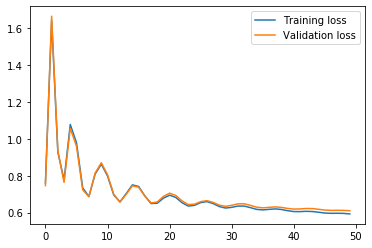

In [11]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [12]:
with torch.no_grad():
    output = model(train_x.double())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.6980842219410808

In [13]:
with torch.no_grad():
    output = model(val_x.double())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.688

In [14]:
test_x = Xvalid.reshape(3000, 1, 48, 48)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([3000, 1, 48, 48])

In [15]:
with torch.no_grad():
    output = model(test_x.double())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)


label= Yvalid.astype(int)
label = torch.from_numpy(label)

In [16]:
accuracy_score(label, predictions)

0.684